## Project 2: Spatial Temporal

#### Goal: To explore different visualization methods to effectively tell the story of Alison's migration patterns, including how they compare to Christian's

#### Imports

In [60]:
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import skmob
from skmob.preprocessing import detection, clustering

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")

import folium
from folium.features import GeoJson

#### Data uploading and cleaning

In [61]:
events = pd.read_csv("/Users/aidan/Documents/applieddatascience/sample_code/GalapagostortoiseMovementEcology Programme_2009_2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_")
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       #'individual_taxon_canonical_name', 'tag_local_identifier',
       'individual_local_identifier']
tortoise = tortoise[cols].assign()
tortoise.insert(loc = 2, column = "timestamp_UTC",
    value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
)
tortoise.insert(loc = 3, column = "timestamp_local", 
    value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
)

tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)

tortoise.insert(loc = 4, column = "minute_diff", 
    value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
        .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
)

tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date

In [62]:
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

In [63]:
import math
def my_haversine(lat1, lon1, lat2, lon2):
    R = 6371e3 # metres
    phi1 = lat1 * math.pi/180 # φ, λ in radians
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + \
        math.cos(phi1) * math.cos(phi2) * \
        math.sin(delta_lambda/2) * math.sin(delta_lambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c # in metres
    return d

#### Import Migration Detection by distance travelled per day from HW_06

- This function created in HW_06 takes in a 'tortoise' df which has lat, long, and time data. It then finds what the total displacemnt for that tortoise was each day(distance between where it started and where it finished). It then plots these over multiple years hoping to visualize migration patterns. Assiming ideal behavior. Displacement will be larger for a small period twice a year during migration, while for the rest of the year, the displacment will be lower.

In [64]:
def migration_detection(tortoise):
    times = tortoise.groupby('date').agg(min_time=('timestamp_local','min'),
                           max_time=('timestamp_local','max'))
    first = tortoise.groupby(['date'])['date','location_long','location_lat'].first().reset_index(drop=True)
    last = tortoise.groupby(['date'])['date','location_long','location_lat'].last().reset_index(drop=True)
    distance_tab = first.merge(last,on='date')
    d = []
    for _,(date,x1,y1,x2,y2)  in distance_tab.iterrows():
        d.append(my_haversine(x1,y1,x2,y2))
    distance_tab['distance']=d
    plt.figure(figsize = (20,5))
    sns.scatterplot(data = distance_tab, x = 'date', y ='distance')    
    return distance_tab
    ## Need to do Alison, Marilyn, Kitty, Connor, Helber, Christian, Steve Devine

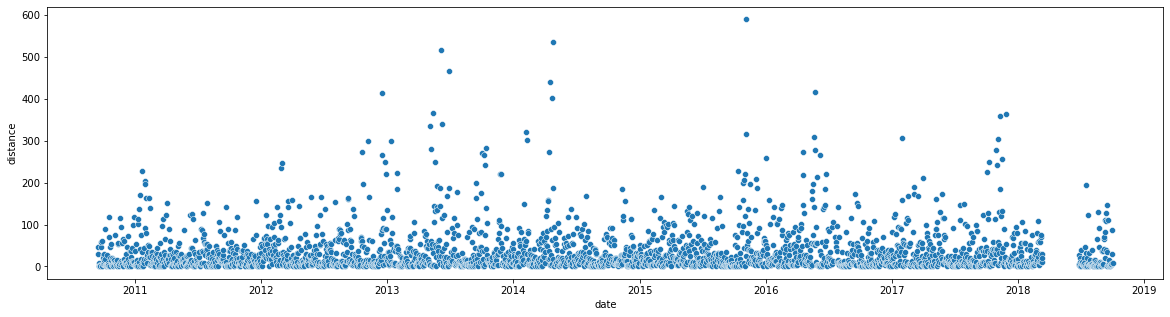

In [65]:
Alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
atable = migration_detection(Alison)

- For Alison, some migration regularity can be detected from the displacemnt data, but it is far from ideal. Some years she moves much further per day on migration than others. Particularl, in 2013, 2014, and 2015, she had some days of very large movement.

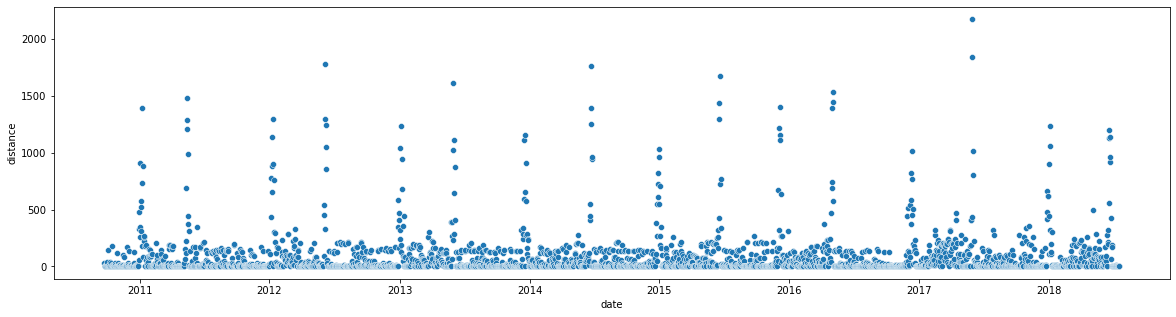

In [66]:
Christian = tortoise[tortoise["individual_local_identifier"] == "Christian"]
ctable = migration_detection(Christian)

- Christian's data is much more regular

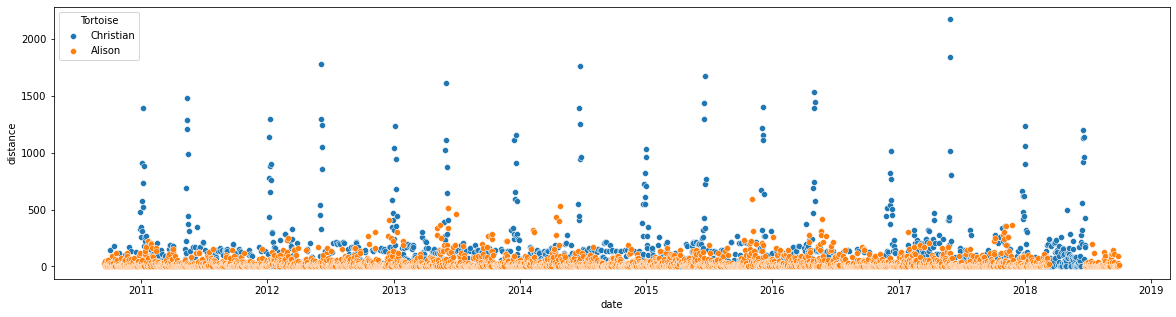

In [67]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = ctable, x = 'date', y ='distance', legend = 'full')   
sns.scatterplot(data = atable, x = 'date', y ='distance', legend = 'full')  
 
plt.legend(title= "Tortoise", loc = 'upper left', labels = ['Christian','Alison'])

- We can overlay the two datasets to see how they cmopare. It is particularly interesting how much further Christian tends to move per day than Alison.

#### Analysis by longitude variation

- Another way to analysis Migration habits, is to look at the variations of Alison's Longitude, as there is a greate longitudinal difference between her two different seasonal locations.

<AxesSubplot: xlabel='date'>

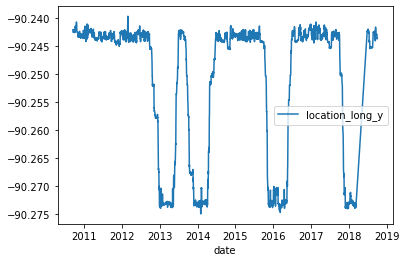

In [68]:
atable.plot(x="date", y="location_long_y")

- This visualization's irregularities match up pretty well with the distance travelled per day visualizations. It seems as if She did not migrate in 2010, 2011, or 2012. And her migration period was smaller in 2013-2014 than in 2014-2019

<AxesSubplot: xlabel='date'>

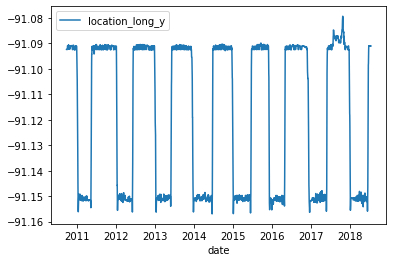

In [69]:
ctable.plot(x="date", y="location_long_y")

- As expected, Christian's longitude is much more regular, implying a regular migration cycle, excluding a small disturbance during late 2017

#### By latitude variation

<AxesSubplot: title={'center': 'Alison'}, xlabel='date'>

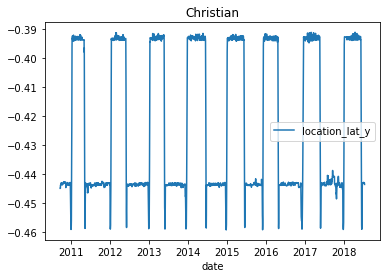

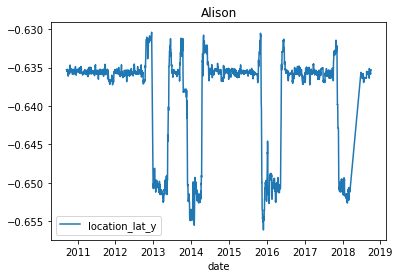

In [70]:
ctable.plot(x="date", y="location_lat_y",title="Christian")
atable.plot(x="date",y="location_lat_y",title="Alison")

- When looking at their respective latitudes over time, similar trends are reflected

#### Trajectory Analysis

- Combining the lat. and long. data, we will plot her Trajectory on a map and see what her movement looks like.

In [71]:
atable['date']=pd.to_datetime(atable['date'])
atable['year']=atable['date'].dt.year
a_traj = skmob.TrajDataFrame(atable, latitude='location_lat_y', longitude='location_long_y', \
     datetime='date', \
)

In [72]:
pal = sns.color_palette('tab10')
color_list = pal.as_hex()
color_list

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [73]:
map_f = a_traj.query("year == 2011").plot_trajectory(zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[1])
a_traj.query("year == 2012").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[2])
a_traj.query("year == 2013").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[3])
a_traj.query("year == 2014").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[4])
a_traj.query("year == 2015").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[5])
a_traj.query("year == 2016").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[6])
a_traj.query("year == 2017").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[7])
a_traj.query("year == 2018").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[8])
a_traj.query("year == 2019").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[9])
map_f






- her route seems to be the same each time that she migrated, lets look at what was going on in 2011 specifically

In [74]:
map_f = a_traj.query("year == 2011").plot_trajectory(zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[1])
map_f

- Our suspicions were correct, for some reason, in 2011, Alison just stayed put in the North-Eastern Location and did not migrate

- Lets see what Christian's migration routes were like and how they compare to Alison's.

In [75]:
pal = sns.color_palette('tab10')
color_list = pal.as_hex()
color_list

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [76]:
ctable['year']=atable['date'].dt.year
c_traj = skmob.TrajDataFrame(ctable, latitude='location_lat_y', longitude='location_long_y', \
     datetime='date', \
)

In [77]:
map_f = folium.Map(location=[-0.7, -90.6], zoom_start=10, width='100%', height='100%')

years = ['2011','2012','2013','2014','2015','2016','2017','2018']
c=1
for y in years:
    c_traj.query(("year =={}").format(y)).plot_trajectory(map_f=map_f,zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[c])
    a_traj.query(("year =={}").format(y)).plot_trajectory(map_f=map_f,zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[c])
    c=c+1
map_f


- It seems that Christian and Alison live on different islands! This explains why there is differences in how much their lat and long change, and why Chrsistian has to move more during migration, as his island is larger.

In [78]:
color_list

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

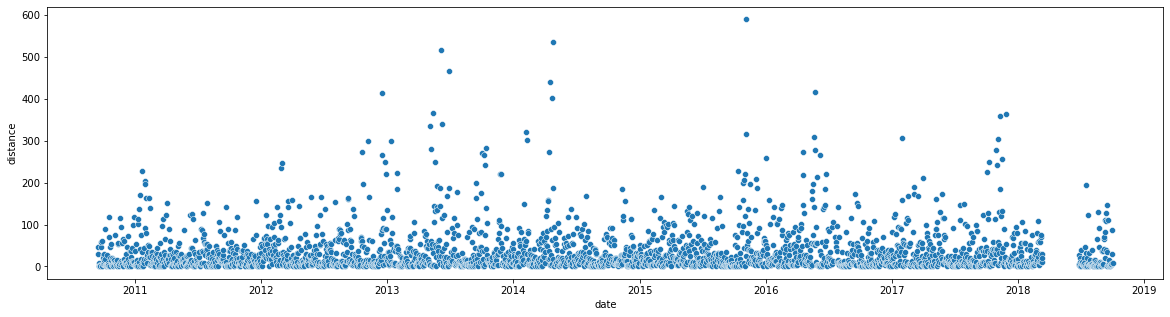

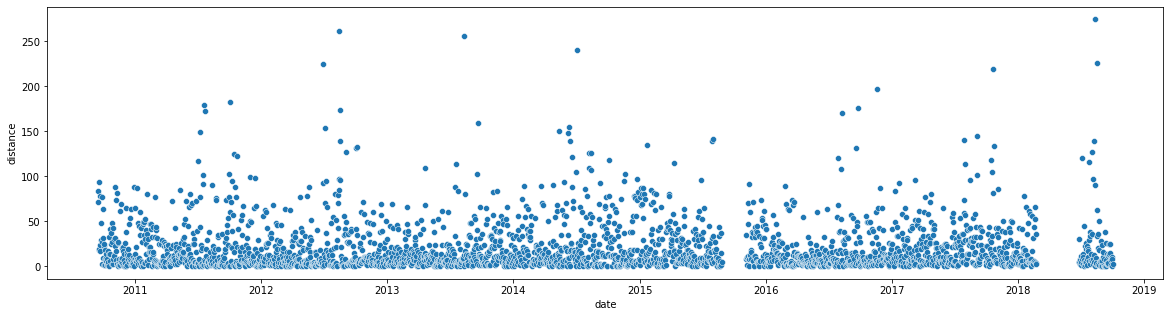

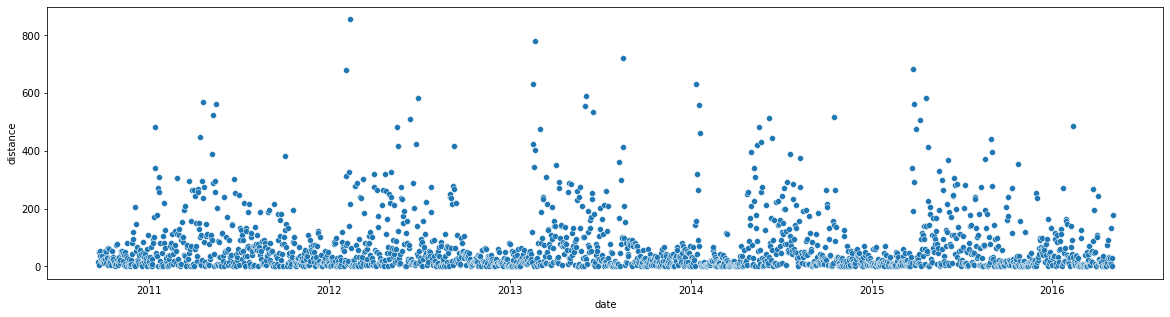

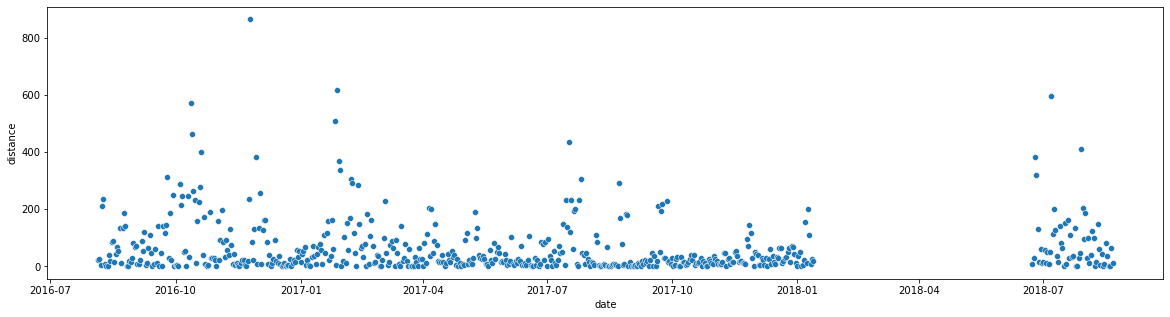

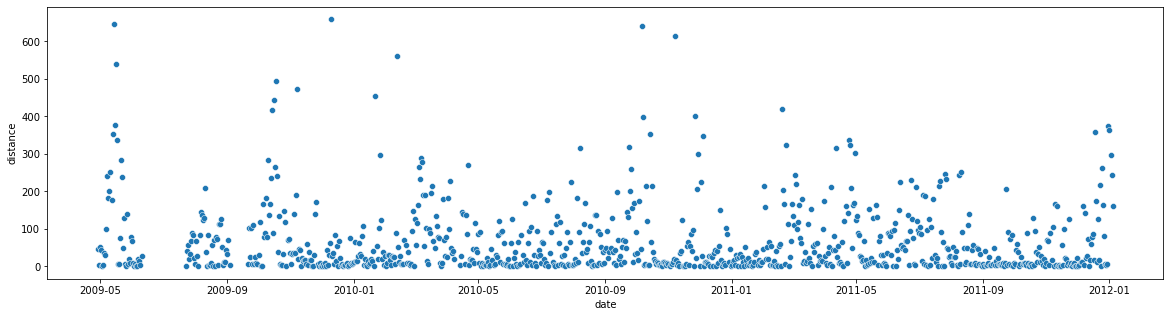

In [79]:
map_f = folium.Map(location=[-0.662, -90.25], zoom_start=13, width='100%', height='100%')


Santa_cruz_east = ['Alison','Kitty','Connor','Harry','Helber']
color_list = pal.as_hex()
color_names = ['Blue','Orange','Green','Red','Purple']
color_labels = dict(zip(color_names, Santa_cruz_east))
c=0
for t in Santa_cruz_east:
    table = migration_detection(tortoise[tortoise["individual_local_identifier"] == t])
    traj = skmob.TrajDataFrame(table, latitude='location_lat_y', longitude='location_long_y', \
     datetime='date', \
    )
    traj.plot_trajectory(map_f=map_f,zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[c])
    c+=1

map_f

In [80]:
color_labels

{'Blue': 'Alison',
 'Orange': 'Kitty',
 'Green': 'Connor',
 'Red': 'Harry',
 'Purple': 'Helber'}

- For a final visualization, above is the trajectory of five tortoises from the same area. Using the legend above, you can see which tortoises moved where.